## Classification automatique (Clustering) sur les eaux

Tutoriel disponible à ce lien : http://eric.univ-lyon2.fr/ricco/cours/didacticiels/Python/cah_kmeans_avec_python.pdf  

&nbsp;

**Description des données**  
On dispose d’un fichier comprenant les variables explicitées ci-dessous pour étudier 57 marques d’eaux en bouteille:  

**NOM** : le nom complet de l’eau inscrit sur l’étiquette.  
**PAYS** : le pays d’origine identifié par les lettres de l’immatriculation automobile officielle.  
**TYPE** : à deux modalités : M    pour  eau minérale ,     S    pour eau de source.  
**PG** : à deux modalités : P   pour eau plate,    G    pour eau gazeuse.  
**CA** : ions calcium en mg/litre.  
**MG** : ions magnésium en mg/litre.  
**NA** : ions sodium en mg/litre.  
**K** : ions potassium en mg/litre.  
**SUL** : ions sulfates en mg/litre.  
**NO3** : ions nitrates en mg/litre.  
**HCO3** : ions carbonates en mg/litre.  
**CL** : ions chlorures en mg/litre.  

##### RUBRIQUES

1. [IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES](#import_check)  

2. [ANALYSE EXPLORATOIRE](#analyse_exploratoire)  

3. [KMEANS](#kmeans)

[REQUIREMENTS.txt](#requirements)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster, metrics

---

## <a id="import_check" style="color:black">1. IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES</a>

In [2]:
df = pd.read_table("../data/csv-txt/eaux/donnees_eaux.txt", encoding="iso-8859-1")

In [3]:
df.head()

,NOM,ACRO,PAYS,TYPE,PG,CA,MG,NA,K,SUL,NO3,HCO3,CL
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [4]:
df.columns = ["nom","acronyme","pays","type","pg","ca","mg","na","k","sul","no3","hco3","cl"]

In [5]:
df.head()

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [6]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nom       57 non-null     object
 1   acronyme  57 non-null     object
 2   pays      57 non-null     object
 3   type      57 non-null     object
 4   pg        57 non-null     object
 5   ca        57 non-null     object
 6   mg        57 non-null     object
 7   na        57 non-null     object
 8   k         57 non-null     object
 9   sul       57 non-null     object
 10  no3       57 non-null     object
 11  hco3      57 non-null     object
 12  cl        57 non-null     object
dtypes: object(13)
memory usage: 43.8 KB


In [7]:
df.iloc[:,5:] = df.iloc[:,5:].replace(",", ".", regex=True)

In [8]:
df.dtypes

nom         object
acronyme    object
pays        object
type        object
pg          object
ca          object
mg          object
na          object
k           object
sul         object
no3         object
hco3        object
cl          object
dtype: object

In [9]:
for i in df.columns[5:]:
    df[i] = pd.to_numeric(df[i])

In [10]:
df.dtypes

nom          object
acronyme     object
pays         object
type         object
pg           object
ca          float64
mg          float64
na          float64
k           float64
sul         float64
no3         float64
hco3        float64
cl          float64
dtype: object

In [11]:
df.isnull().sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [12]:
# Pour détecter les chaînes vides

df.apply(lambda x: x == "", axis=1).sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [14]:
df.select_dtypes(include=["object"]).describe()

,nom,acronyme,pays,type,pg
count,57,57,57,57,57
unique,57,56,6,2,2
top,Evian,VERN,F,M,P
freq,1,2,40,38,41


In [15]:
df[df.duplicated(subset=["acronyme"], keep=False)]

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
42,Vernière,VERN,F,M,G,190.0,72.0,154.0,49.0,158.0,0.0,1170.0,18.0
53,Vernet,VERN,F,M,G,33.5,17.6,192.0,28.7,14.0,1.0,734.0,6.4


In [16]:
df.loc[df.nom == "Vernière", "acronyme"] = "VERNI"

In [17]:
# check
df.loc[df.nom == "Vernière", "acronyme"]

42    VERNI
Name: acronyme, dtype: object

## <a id="analyse_exploratoire" style="color:black">2. ANALYSE EXPLORATOIRE</a>

Se référer au notebook 'acp eaux' pour l'analyse exploratoire détaillée

## <a id="kmeans" style="color:black">3. Kmeans</a>

In [18]:
## Standardisation
sc = StandardScaler()
arr = sc.fit_transform(df.iloc[:,5:])

In [19]:
kmeans = cluster.KMeans(n_clusters=5)
kmeans.__dict__

{'n_clusters': 5,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'precompute_distances': 'deprecated',
 'n_init': 10,
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'n_jobs': 'deprecated',
 'algorithm': 'auto'}

In [20]:
kmeans.fit(arr)
kmeans.__dict__

{'n_clusters': 5,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'precompute_distances': 'deprecated',
 'n_init': 10,
 'verbose': 0,
 'random_state': None,
 'copy_x': True,
 'n_jobs': 'deprecated',
 'algorithm': 'auto',
 'n_features_in_': 8,
 '_n_threads': 8,
 '_n_init': 10,
 '_tol': 0.0001,
 '_algorithm': 'elkan',
 'cluster_centers_': array([[-3.59541224e-01, -4.37935664e-01, -3.70143406e-01,
         -3.32229805e-01, -2.89937685e-01, -2.36053161e-01,
         -3.74658737e-01, -2.05078989e-01],
        [ 1.07779794e-01,  1.37484402e+00,  1.90408024e+00,
          1.94971835e+00, -2.49531040e-01, -1.84809950e-01,
          2.15456151e+00,  4.41420888e-01],
        [ 2.84899783e+00,  1.74294916e+00, -4.00620853e-01,
         -2.80361482e-01,  3.05873428e+00, -3.64444823e-01,
         -2.39106339e-01, -2.27651374e-01],
        [ 2.03298254e-03, -6.22549752e-01, -4.21079807e-01,
         -4.09387161e-01, -3.64644775e-01,  3.23959800e+00,
         -2.33384379e-01, -2.41032819e-01

In [21]:
## Tri des indices de classes
idk = np.argsort(kmeans.labels_)
idk

array([ 0, 25, 26, 27, 55, 29, 31, 32, 33, 35, 24, 37, 39, 40, 43, 45, 48,
       49, 50, 53, 54, 38, 23, 28, 21,  1,  2,  3,  4,  6,  7, 11, 12,  8,
       56, 14, 20, 19, 17, 13, 52, 18,  5, 46, 34, 42, 41, 10, 47,  9, 15,
       44, 22, 51, 36, 16, 30], dtype=int64)

In [22]:
pd.DataFrame({"Eau":df.nom[idk], "Cluster":kmeans.labels_[idk]})

,Eau,Cluster
0,Evian,0
25,San Benedetto,0
26,San Pellegrino,0
27,Levissima,0
55,sidi ali,0
29,San Antonio,0
31,Saint Benoit,0
32,Plancoët,0
33,Saint Alix,0
35,St-Georges/Corse,0


In [23]:
## Calcul de la distance des individus aux centres de classes

d_i_G = kmeans.transform(arr)
d_i_G

array([[ 0.55716152,  4.38933892,  4.96356459,  3.30158592,  8.92061927],
       [ 0.37642763,  4.62384177,  5.30047791,  3.26422721,  8.80801879],
       [ 0.38444919,  4.66822755,  5.26956739,  3.68159296,  8.99771615],
       [ 0.79082156,  4.23473487,  4.72952182,  3.90852681,  8.62571476],
       [ 0.77751527,  5.09471956,  5.70967004,  3.82785744,  9.33707641],
       [ 4.75294962,  1.57899432,  6.07753435,  6.01352109,  6.91261845],
       [ 0.62754304,  5.03658515,  5.58230661,  3.63576785,  9.27915177],
       [ 0.84736272,  4.88964104,  5.63714205,  3.00453279,  9.24617136],
       [ 0.26520532,  4.76615448,  5.14953261,  3.54404656,  9.05111115],
       [ 3.11565817,  4.36004977,  2.35602104,  4.82856733,  7.41151726],
       [ 7.99604027,  3.90087122,  8.43145211,  8.90832111,  7.77591392],
       [ 0.26520532,  4.76615448,  5.14953261,  3.54404656,  9.05111115],
       [ 0.53297099,  4.81947664,  5.41708189,  3.86146488,  9.15854465],
       [ 1.55331206,  4.72883077,  5.1

In [24]:
## Détection du nombre "optimal" de classes
scr = []
K = np.arange(8)
for k in K:
    km = cluster.KMeans(n_clusters = k + 3)
    km.fit(arr)
    scr.append(km.inertia_)

scr

[198.92936631233025,
 152.08139187296945,
 107.68507873709068,
 71.95570893899928,
 56.76821568526448,
 44.649860421713335,
 36.87467946608244,
 30.580206548747423]

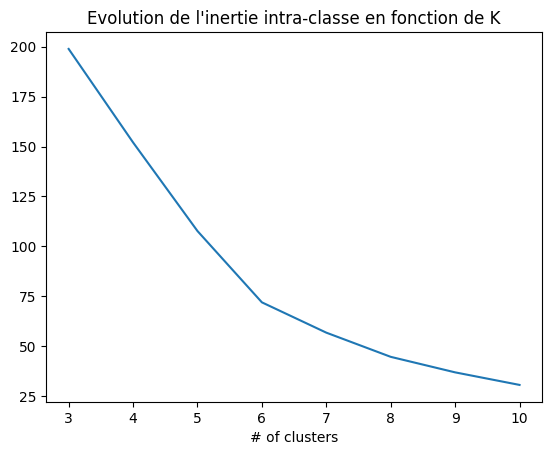

In [25]:
# graphique de l'évolution de l'inertie intra-classe en fonction de K

plt.title("Evolution de l'inertie intra-classe en fonction de K")
plt.xlabel("# of clusters")
plt.plot(K + 3, scr)
plt.show()

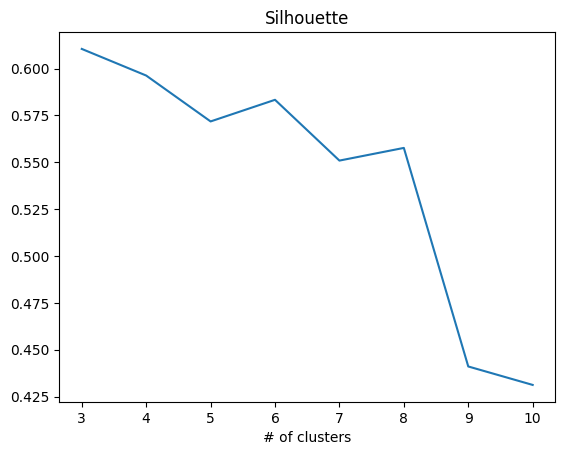

In [26]:
#utilisation de la métrique "silhouette"

res= np.arange(8,dtype="double")
for k in K:
    km = cluster.KMeans(n_clusters=k+3)
    km.fit(arr)
    res[k] = metrics.silhouette_score(arr,km.labels_)

plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(K + 3,res)
plt.show()

In [27]:
## On relance l'algorithme avec k=6

kmeans = cluster.KMeans(n_clusters=6)
kmeans.fit(arr)

KMeans(n_clusters=6)

In [28]:
idk = np.argsort(kmeans.labels_)
pd.DataFrame({"Eau":df.nom[idk], "Cluster":kmeans.labels_[idk]})

,Eau,Cluster
0,Evian,0
25,San Benedetto,0
27,Levissima,0
55,sidi ali,0
29,San Antonio,0
31,Saint Benoit,0
32,Plancoët,0
33,Saint Alix,0
35,St-Georges/Corse,0
37,Hildon blanche,0


In [32]:
d_i_G = kmeans.transform(arr)
d_i_G

array([[ 0.58275598,  4.43142152,  8.0386448 ,  3.30158592,  8.92061927,
         3.19079736],
       [ 0.35579874,  4.76608992,  8.22276141,  3.26422721,  8.80801879,
         3.46429572],
       [ 0.35919712,  4.74174096,  8.24480128,  3.68159296,  8.99771615,
         3.52565996],
       [ 0.83687575,  4.18670238,  7.85733454,  3.90852681,  8.62571476,
         3.06008717],
       [ 0.73212033,  5.17968201,  8.64175381,  3.82785744,  9.33707641,
         3.96833085],
       [ 4.77826935,  5.68139848,  3.92032919,  6.01352109,  6.91261845,
         2.05767669],
       [ 0.57893363,  5.05562272,  8.60413397,  3.63576785,  9.27915177,
         3.89597345],
       [ 0.80959532,  5.11341558,  8.45423107,  3.00453279,  9.24617136,
         3.75315528],
       [ 0.25827262,  4.62059784,  8.37513177,  3.54404656,  9.05111115,
         3.59723369],
       [ 3.18033887,  1.81635486,  7.64387311,  4.82856733,  7.41151726,
         3.45009799],
       [ 8.01759708,  8.18899616,  1.77404522,  8.

In [33]:
## Interprétation des classes (univariée)

#moyenne par variable
m = df.mean()

print("Moyennes par variables \n")
print(m)
print("\n===========================================\n")

#TSS
TSS = df.shape[0]*df.var(ddof=0)
print(TSS)


Moyennes par variables 

ca      102.458246
mg       25.861930
na       93.851754
k        11.090351
sul     135.661404
no3       3.834211
hco3    442.166842
cl       52.473684
dtype: float64


ca      8.060394e+05
mg      4.484471e+04
na      2.178853e+06
k       3.343664e+04
sul     6.069173e+06
no3     2.490926e+03
hco3    2.072161e+07
cl      1.149148e+06
dtype: float64


C:\Users\Nelly\AppData\Local\Temp\ipykernel_10976\945041153.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m = df.mean()
C:\Users\Nelly\AppData\Local\Temp\ipykernel_10976\945041153.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TSS = df.shape[0]*df.var(ddof=0)


In [34]:
# Interprétation des classes (univariée)

#dataframe conditionnellement aux groupes
gb_km = df.groupby(kmeans.labels_)

#effectifs conditionnels
nk_km= gb_km.size()

#moyennes conditionnelles
mk_km= gb_km.mean()

print("Moyennes conditionnelles aux groupes \n")
print(mk_km)
print("\n===========================================\n")

#pour chaque groupe, écart à la moyenne par variable
EMk_km= (mk_km - m)**2

#pondéré par les effectifs du groupe
EM_km = EMk_km.multiply(nk_km,axis=0)

#somme des valeurs => BSS
BSS_km = np.sum(EM_km,axis=0)

#carré du rapport de corrélation
eta2_km = BSS_km/TSS

print("Part de la variance totale expliquée par l'appartenance aux groupes \n")
print(eta2_km.sort_values(ascending=False))

Moyennes conditionnelles aux groupes 

           ca         mg          na           k          sul        no3  \
0   55.900513  12.493077   20.916667    3.052564    28.023077   2.320513   
1  394.600000  70.980000   21.140000    3.980000  1016.840000   1.230000   
2  134.500000  90.050000  809.000000  116.500000    24.500000   0.500000   
3  102.700000   8.400000   11.525000    1.175000    16.675000  25.250000   
4  354.000000  83.000000  653.000000   22.000000  1055.000000   0.000000   
5  108.866667  55.883333  351.833333   38.916667    64.150000   3.316667   

          hco3          cl  
0   216.184615   22.048718  
1   282.320000   30.980000  
2  2787.755000  237.500000  
3   301.450000   18.250000  
4   225.000000  982.000000  
5  1392.400000   74.366667  


Part de la variance totale expliquée par l'appartenance aux groupes 

na      0.916012
k       0.901792
hco3    0.900847
sul     0.871856
cl      0.851466
no3     0.801451
mg      0.786735
ca      0.715653
dtype: float64


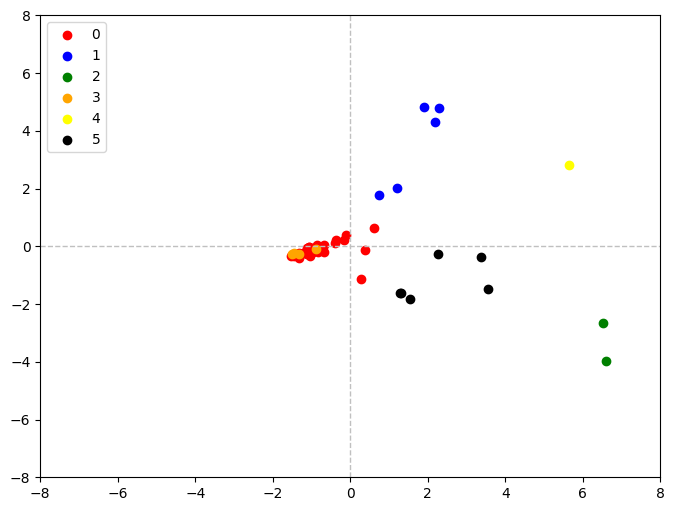

In [35]:
## Affichage des clusters dans le 1er plan factoriel

coords = PCA(svd_solver="full").fit_transform(arr)

plt.figure(figsize=(8,6))

for couleur, k in zip(['red','blue','green','orange',"yellow","black"], np.unique(kmeans.labels_)):
    plt.scatter(coords[kmeans.labels_ == k , 0], coords[kmeans.labels_ == k, 1], c=couleur, label=k)

plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.legend(loc=2)
plt.axvline(0, color="silver", linestyle="dashed", linewidth=1)
plt.axhline(0, color="silver", linestyle="dashed", linewidth=1)
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.8</span>

Requirements.txt  

```
absl-py==2.1.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0       
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==4.2.4
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.4
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
gast==0.3.3
google-auth==1.35.0
google-auth-oauthlib==0.4.6        
google-pasta==0.2.0
grpcio==1.66.2
h5py==2.10.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==8.5.0
importlib-resources==6.4.5
ipykernel==6.25.2
ipython==8.12.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.1.1
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-client==8.3.1
jupyter-console==6.6.3
jupyter-core==5.3.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter-server==2.7.3
jupyter-server-terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-server==2.25.0
jupyterlab-widgets==3.0.9
Keras==2.4.3
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
Markdown==3.7
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
missingno==0.5.2
mistune==3.0.1
multimethod==1.8
nbclient==0.8.0
nbconvert==7.8.0
nbformat==5.9.2
nest-asyncio==1.5.8
networkx==3.1
notebook==7.0.3
notebook-shim==0.2.3
numpy==1.22.0
oauthlib==3.2.2
opt-einsum==3.4.0
overrides==7.4.0
packaging==23.1
pandas==1.4.0
pandas-profiling==3.3.0
pandocfilters==1.5.0
parso==0.8.3
patsy==0.5.3
pexpect==4.8.0
phik==0.12.3
pickleshare==0.7.5
Pillow==10.0.1
pkgutil-resolve-name==1.3.10
platformdirs==3.10.0
prometheus-client==0.17.1
prompt-toolkit==3.0.39
protobuf==3.20.3
psutil==5.9.5
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.1
pyasn1-modules==0.4.1
pycparser==2.21
pydantic==1.9.2
Pygments==2.16.1
pyparsing==3.1.1
python-dateutil==2.8.2
python-json-logger==2.0.7
pytz==2023.3.post1
PyWavelets==1.4.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==25.1.1
qtconsole==5.4.4
QtPy==2.4.0
referencing==0.30.2
requests==2.28.0
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.10.3
rsa==4.9
scikit-learn==0.23.2
scipy==1.4.1
seaborn==0.11.2
Send2Trash==1.8.2
six==1.16.0
sniffio==1.3.0
soupsieve==2.5
stack-data==0.6.2
statsmodels==0.13.5
tangled-up-in-unicode==0.2.0
tensorboard==2.2.2
tensorboard-plugin-wit==1.8.1
tensorflow==2.2.0
tensorflow-estimator==2.2.0
termcolor==2.4.0
terminado==0.17.1
threadpoolctl==3.5.0
tinycss2==1.2.1
tomli==2.0.1
tornado==6.3.3
tqdm==4.64.1
traitlets==5.10.0
typing-extensions==4.7.1
uri-template==1.3.0
urllib3==1.26.16
visions==0.7.5
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.6.3
werkzeug==3.0.4
widgetsnbextension==4.0.9
wrapt==1.16.0
xlrd==2.0.1
zipp==3.20.2
```